In [23]:
import numpy as np
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Convolution2D
from keras.layers import Flatten

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
import pickle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import SGD
 

In [24]:
def cnn_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    
    return model

In [25]:
def cnn_vgg16_model():
    IMAGE_SIZE=[64,64]
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
      layer.trainable = False
  
    x = Flatten()(vgg.output)
    # x = Dense(1000, activation='relu')(x)
    prediction = Dense((n_classes), activation='softmax')(x)

    # create a model object
    model = Model(inputs=vgg.input, outputs=prediction)
    
    return model

In [26]:
def resnet():
    IMAGE_SIZE=[64,64]
    base_model = ResNet50(input_shape=IMAGE_SIZE + [3],include_top=False, weights='imagenet',pooling='avg')
     
    # Training only top layers i.e. the layers which we have added in the end
    for layer in base_model.layers:
        
        layer.trainable = False
        x = base_model.output
        
    # x = GlobalAveragePooling2D()(x)
    #x = Dense(1024, activation='relu')(x)
        predictions = Dense(4, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        return model

# image to array conversion

In [27]:
EPOCHS = 200
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = 'dataset'
width=64
height=64
depth=3
loss = 'categorical_crossentropy'
patience = 50


In [28]:
# The callbacks executed during training if model exhibits any following behaviour
log_file_path = directory_root + '_plant_disease.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = directory_root + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]


In [29]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# loading images

In [30]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ... ")
        plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/") 
        
        if plant_disease_folder == 'Blight':
            img_count =2146 
        elif plant_disease_folder == 'Common_Rust':
            img_count = 2498
        elif plant_disease_folder == 'Gray_Leaf_Spot':
            img_count = 1574
        elif plant_disease_folder == 'Healthy':
            img_count = 2324 
        
        
        for image in plant_disease_image_list[:img_count]:
            image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)
                  
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Blight ... 
[INFO] Processing Common_Rust ... 
[INFO] Processing Gray_Leaf_Spot ... 
[INFO] Processing Healthy ... 
[INFO] Image loading completed


### printing size of the dataset

In [31]:
image_size = len(image_list)

print(image_size)

8541


In [32]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)


In [33]:
print(label_binarizer.classes_)

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']


## image normalisation

In [34]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0
print(np_image_list)

[[[[0.0902   0.3098   0.2274  ]
   [0.1333   0.3333   0.2354  ]
   [0.3372   0.51     0.51    ]
   ...
   [0.02745  0.4548   0.353   ]
   [0.01569  0.4548   0.357   ]
   [0.011765 0.4314   0.3176  ]]

  [[0.1294   0.2705   0.3687  ]
   [0.1412   0.3452   0.4392  ]
   [0.3137   0.4824   0.5254  ]
   ...
   [0.00784  0.4785   0.4119  ]
   [0.02745  0.4902   0.447   ]
   [0.04315  0.506    0.5137  ]]

  [[0.2864   0.4236   0.4902  ]
   [0.5137   0.5293   0.4824  ]
   [0.7686   0.655    0.5605  ]
   ...
   [0.051    0.498    0.5527  ]
   [0.04706  0.4785   0.596   ]
   [0.0549   0.3726   0.5254  ]]

  ...

  [[0.0863   0.498    0.353   ]
   [0.1333   0.5527   0.4236  ]
   [0.1372   0.541    0.4197  ]
   ...
   [0.929    0.788    0.6943  ]
   [0.816    0.6904   0.6704  ]
   [0.4626   0.596    0.541   ]]

  [[0.1765   0.6      0.498   ]
   [0.1412   0.5293   0.3804  ]
   [0.1098   0.5137   0.4158  ]
   ...
   [0.2588   0.4353   0.3293  ]
   [0.04706  0.498    0.349   ]
   [0.0784   0.4863   

## spliting the dataset  

In [35]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [36]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# model selection

In [37]:
select_model_to_run = input("Select the model to run. \n1. CNN model \n2. VGG model\n3. Resnet model\n4. CNN with SVM loss\n")
if(select_model_to_run == '1'):
    model_name = 'cnn'
    print("Model CNN executing ...")
    model = cnn_model()
elif(select_model_to_run == '2'):
    model_name = 'vgg16'
    print("Model VGG16 executing ...")
    model = cnn_vgg16_model()
elif(select_model_to_run == '3'):
    model_name = 'resnet'
    print("Model Resnet executing ...")
    model = resnet()   
elif(select_model_to_run == '4'):
    model_name='cnn_svm'
    loss = 'squared_hinge' # will act as svm the last layer 
    model = cnn_model()
    print("CNN + SVM executing ...")
else:
    print("Invalid selection")
    

Select the model to run. 
1. CNN model 
2. VGG model
3. Resnet model
4. CNN with SVM loss
4
CNN + SVM executing ...


In [38]:
# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
loss = loss,
optimizer='adam',
metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 21, 21, 64)       

In [39]:
# fit the model

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/200
213/213 [==============================] - 33s 153ms/step - loss: 0.9492 - accuracy: 0.7934 - val_loss: 1.4826 - val_accuracy: 0.2674
Epoch 2/200
213/213 [==============================] - 31s 148ms/step - loss: 0.9038 - accuracy: 0.8426 - val_loss: 0.9388 - val_accuracy: 0.8022
Epoch 3/200
213/213 [==============================] - 31s 147ms/step - loss: 0.8732 - accuracy: 0.8731 - val_loss: 0.9904 - val_accuracy: 0.7531
Epoch 4/200
213/213 [==============================] - 31s 148ms/step - loss: 0.8733 - accuracy: 0.8743 - val_loss: 0.9737 - val_accuracy: 0.7753
Epoch 5/200
213/213 [==============================] - 31s 148ms/step - loss: 0.8764 - accuracy: 0.8694 - val_loss: 1.1122 - val_accuracy: 0.6349
Epoch 6/200
213/213 [==============================] - 31s 148ms/step - loss: 0.8576 - accuracy: 0.8893 - val_loss: 1.0386 - val_accuracy: 0.7098
Epoch 7/200
213/213 [==============================] - 31s 148ms/step - loss: 0.8550 - accuracy: 0.8909 - val_loss: 1.2902 -

Epoch 57/200
213/213 [==============================] - 32s 148ms/step - loss: 0.8319 - accuracy: 0.9172 - val_loss: 0.8630 - val_accuracy: 0.8871
Epoch 58/200
213/213 [==============================] - 32s 148ms/step - loss: 0.8333 - accuracy: 0.9153 - val_loss: 0.8991 - val_accuracy: 0.8479
Epoch 59/200
213/213 [==============================] - 32s 148ms/step - loss: 0.8283 - accuracy: 0.9210 - val_loss: 0.9618 - val_accuracy: 0.7864
Epoch 60/200
213/213 [==============================] - 32s 148ms/step - loss: 0.8296 - accuracy: 0.9196 - val_loss: 0.8507 - val_accuracy: 0.8970
Epoch 61/200
213/213 [==============================] - 32s 148ms/step - loss: 0.8350 - accuracy: 0.9137 - val_loss: 0.8464 - val_accuracy: 0.9023
Epoch 62/200
213/213 [==============================] - 32s 148ms/step - loss: 0.8252 - accuracy: 0.9235 - val_loss: 0.9304 - val_accuracy: 0.8192
Epoch 63/200
213/213 [==============================] - 32s 148ms/step - loss: 0.8301 - accuracy: 0.9185 - val_loss: 0

213/213 [==============================] - 32s 152ms/step - loss: 0.8163 - accuracy: 0.9328 - val_loss: 0.8869 - val_accuracy: 0.8602
Epoch 113/200
213/213 [==============================] - 32s 152ms/step - loss: 0.8246 - accuracy: 0.9246 - val_loss: 0.8305 - val_accuracy: 0.9193
Epoch 114/200
213/213 [==============================] - 33s 153ms/step - loss: 0.8182 - accuracy: 0.9309 - val_loss: 0.9348 - val_accuracy: 0.8133
Epoch 115/200
213/213 [==============================] - 32s 152ms/step - loss: 0.8243 - accuracy: 0.9246 - val_loss: 1.0336 - val_accuracy: 0.7156
Epoch 116/200
213/213 [==============================] - 32s 152ms/step - loss: 0.8261 - accuracy: 0.9232 - val_loss: 0.8735 - val_accuracy: 0.8748
Epoch 117/200
213/213 [==============================] - 32s 151ms/step - loss: 0.8101 - accuracy: 0.9387 - val_loss: 0.9142 - val_accuracy: 0.8350
Epoch 118/200
213/213 [==============================] - 32s 152ms/step - loss: 0.8256 - accuracy: 0.9236 - val_loss: 0.9231 -

213/213 [==============================] - 32s 152ms/step - loss: 0.8119 - accuracy: 0.9375 - val_loss: 0.8260 - val_accuracy: 0.9228
Epoch 168/200
213/213 [==============================] - 32s 152ms/step - loss: 0.8139 - accuracy: 0.9351 - val_loss: 0.9354 - val_accuracy: 0.8122
Epoch 169/200
213/213 [==============================] - 32s 152ms/step - loss: 0.8184 - accuracy: 0.9312 - val_loss: 0.8161 - val_accuracy: 0.9333
Epoch 170/200
213/213 [==============================] - 33s 153ms/step - loss: 0.8188 - accuracy: 0.9303 - val_loss: 0.7973 - val_accuracy: 0.9520
Epoch 171/200
213/213 [==============================] - 33s 153ms/step - loss: 0.8175 - accuracy: 0.9324 - val_loss: 0.8108 - val_accuracy: 0.9386
Epoch 172/200
213/213 [==============================] - 33s 153ms/step - loss: 0.8166 - accuracy: 0.9325 - val_loss: 0.9649 - val_accuracy: 0.7847
Epoch 173/200
213/213 [==============================] - 32s 152ms/step - loss: 0.8180 - accuracy: 0.9315 - val_loss: 1.0128 -

# plotting graphs

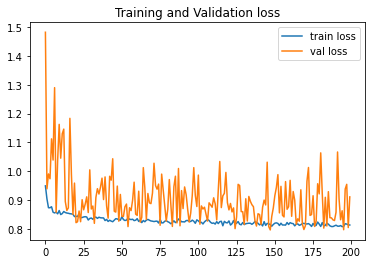

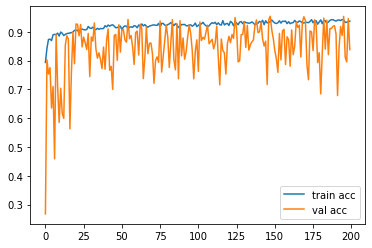

In [40]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation loss')
plt.savefig('LossVal_loss ' + model_name )
plt.legend()
plt.show()


# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.savefig('AccVal_acc ' + model_name)
plt.legend()
plt.show()

In [41]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
1709/1709 [==============================] - 2s 1ms/step
Test Accuracy: 83.7916910648346


In [42]:
print("[INFO] Saving model...")
#pickle.dump(model,open('cnn_model_plant.pkl', 'wb'))
model.save(model_name + ' model_plantdisease.h5')

[INFO] Saving model...


In [ ]:
# Importing the important libraries
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import SGD
 
# Download the architecture of ResNet50 with ImageNet weights
IMAGE_SIZE=[64,64]
base_model = ResNet50(input_shape=IMAGE_SIZE + [3],include_top=False, weights='imagenet')
 
                
# Taking the output of the last convolution block in ResNet50
x = base_model.output
 
# Adding a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)
 
# Adding a fully connected layer having 1024 neurons
x = Dense(1024, activation='relu')(x)
 
# Adding a fully connected layer having 2 neurons which will
# give the probability of image having either dog or cat
predictions = Dense(4, activation='softmax')(x)
 
# Model to be trained
model = Model(inputs=base_model.input, outputs=predictions)
 
# Training only top layers i.e. the layers which we have added in the end
for layer in base_model.layers:
    layer.trainable = False
 
# Compiling the model
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics = ['accuracy'])
 
# Creating objects for image augmentations
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
 
test_datagen = ImageDataGenerator(rescale = 1./255)
 
# Proving the path of training and test dataset
# Setting the image input size as (224, 224)
# We are using class mode as binary because there are only two classes in our data
training_set = train_datagen.flow_from_directory('dataset',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
 
test_set = test_datagen.flow_from_directory('dataset',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')
 
# Training the model for 5 epochs
model.fit_generator(training_set,
                         steps_per_epoch = 50,
                         epochs = 5,
                         validation_data = test_set,
                         )
 
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )
    
    
# # We will try to train the last stage of ResNet50
# for layer in base_model.layers[0:143]:
#   layer.trainable = False
 
# for layer in base_model.layers[143:]:
#   layer.trainable = True
 
# # Training the model for 10 epochs
# model.fit_generator(training_set,
#                          steps_per_epoch = 80,
#                          epochs = 10,
#                          validation_data = test_set,
#                          )
 
# Saving the weights in the current directory
model.save_weights("resnet50_weights.h5")
 
# Predicting the final result of image


In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('cat_or_dog_test.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)\
 
# Expanding the 3-d image to 4-d image.
# The dimensions will be Batch, Height, Width, Channel
test_image = np.expand_dims(test_image, axis = 0)
 
# Predicting the final class
result = model.predict(test_image)[0].argmax()
 
# Fetching the class labels
labels = training_set.class_indices
labels = list(labels.items())
 
# Printing the final label
for label, i in labels:
    if i == result:
        print("The test image has: ", label)
        break